In [1]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Read the file
dataPath = "C:/Users/shash/Documents/MScA/Courses/Summer 2021/Advanced Machine Learning/Session 6/Toxic Comment Data/jigsaw-toxic-comment-classification-challenge/"
train = pd.read_csv(dataPath + 'train.csv/train.csv', index_col=0)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [4]:
types = list(train)[1:]
print(types)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


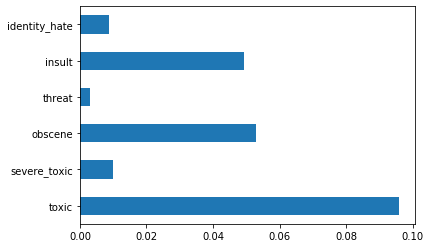

In [5]:
train[types].mean().plot(kind='barh')

In [6]:
# number of clean comments
nb_clean = (train[types].sum(axis=1)==0).sum()
print('clean:',nb_clean,'(',round(100*nb_clean/len(train),2),'% )')

clean: 143346 ( 89.83 % )


# Test labels disclosure

Soon after closing the competition Kaggle added test data labels to the Data Page. Usually this information is not provided, but in this case Jigsaw have asked to provide it to community for continued model improvements and research. 
Some of the test samples were not labelled and were not used for scoring. Value of -1 indicates them. 

Remove labelled samples from the test set and add them to the train set. 

In [7]:
test = pd.read_csv(dataPath + 'test.csv/test.csv', index_col=0)
test_labels = pd.read_csv(dataPath + 'test_labels.csv/test_labels.csv', index_col=0)
print(test_labels.head())
labelled_test = test.join(test_labels)
disclosed = labelled_test.toxic > -1
print(disclosed .mean(),'% of test is labelled')
train = train.append(labelled_test[disclosed])
test = labelled_test[~disclosed][['comment_text']]
print(train.shape,test.shape)
train.to_csv(dataPath+'tc_train.csv')
test.to_csv(dataPath+'tc_test.csv')

                  toxic  severe_toxic  obscene  threat  insult  identity_hate
id                                                                           
00001cee341fdb12     -1            -1       -1      -1      -1             -1
0000247867823ef7     -1            -1       -1      -1      -1             -1
00013b17ad220c46     -1            -1       -1      -1      -1             -1
00017563c3f7919a     -1            -1       -1      -1      -1             -1
00017695ad8997eb     -1            -1       -1      -1      -1             -1
0.41770912224804785 % of test is labelled
(223549, 7) (89186, 1)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223549 entries, 0000997932d777bf to fffb5451268fb5ba
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   223549 non-null  object
 1   toxic          223549 non-null  int64 
 2   severe_toxic   223549 non-null  int64 
 3   obscene        223549 non-null  int64 
 4   threat         223549 non-null  int64 
 5   insult         223549 non-null  int64 
 6   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 13.6+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89186 entries, 00001cee341fdb12 to ffffce3fb183ee80
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  89186 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


# FastText

Below we will use FastText embeddings [crawl-300d-2M.vec](https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M.vec.zip) - 2 million word vectors trained on Common Crawl (600B tokens). These vectors in dimension 300 were obtained using model described in [Bojanowski et al. (2016)](https://arxiv.org/abs/1607.04606). Authors proposed a new approach based on the skipgram model, where each word is represented as a bag of character n-grams. A vector representation is associated to each character n-gram; words being represented as the sum of these representations.   
File *crawl-300d-2M.vec* with word vectors has the following format.  
The first line of the file contains the number of words in the vocabulary and the size of the vectors. Each line contains a word followed by its vectors, like in the default fastText text format. Each value is space separated. Words are ordered by descending frequency.  
Create dictionary with words as keys and embeddings as values.

In [10]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index

In [11]:
embeddings_path = 'C:/Users/shash/Documents/MScA/Courses/Summer 2021/Advanced Machine Learning/Session 6/crawl-300d-2M.vec/'
embeddings_index = get_embeddings(embeddings_path+'crawl-300d-2M.vec')

In [12]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

# Do these steps for Train and Test data
train['comment_text'] = train.comment_text.apply(preprocess)
test['comment_text'] = test.comment_text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer_train = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer_train.fit(train.comment_text)


top_words_train = set(vectorizer_train.vocabulary_.keys())
top_words_train.add(UNKNOWN_PROXY)
print(len(top_words_train),'top words train')

####CHECK IF THE BELOW IS CORRECT WITH TAMER#########
vectorizer_test = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer_test.fit(test.comment_text)

top_words_test = set(vectorizer_test.vocabulary_.keys())
top_words_test.add(UNKNOWN_PROXY)
print(len(top_words_test),'top words test')

Creating the vocabulary of words occurred more than 5
45259 top words train
25113 top words test


In [14]:
print('First 10 out of "top_words_train": \n',list(top_words_train)[:10])
print('Is "unknown" in top_words_train? \n','unknown' in top_words_train)
### Test
print("####")
print('\nFirst 10 out of "top_words_test": \n',list(top_words_test)[:10])
print('Is "unknown" in top_words_test? \n','unknown' in top_words_test)

First 10 out of "top_words_train": 
 ['hatred', 'unworkable', 'textile', 'vivid', 'cong', 'importing', 'wh', 'jp', 'astrological', 'så']
Is "unknown" in top_words_train? 
 True
####

First 10 out of "top_words_test": 
 ['hatred', 'importing', 'wh', 'jp', 'så', 'behaved', 'involves', 'labs', 'deals', 'phony']
Is "unknown" in top_words_test? 
 True


### Filter unknown words

In [15]:
def filter_unknown(text, vocabulary, proxy):
    return ' '. \
join([w if w in vocabulary else proxy for w in text.split(' ')])

In [16]:
train['comment_text'][:2]

id
0000997932d777bf    explanation why the edits made under my userna...
000103f0d9cfb60f    d'aww  he matches this background colour i'm s...
Name: comment_text, dtype: object

In [17]:
test['comment_text'][:2]

id
00001cee341fdb12    yo bitch ja rule is more succesful then you'll...
0000247867823ef7       from rfc       the title is fine as it is  ...
Name: comment_text, dtype: object

In [18]:
train['comment_text'] = train.comment_text.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words_train), \
                      UNKNOWN_PROXY))

test['comment_text'] = test.comment_text.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words_test), \
                      UNKNOWN_PROXY))

In [19]:
train['comment_text'][:2]

id
0000997932d777bf    explanation why the edits made under my userna...
000103f0d9cfb60f    unknown unknown he matches this background col...
Name: comment_text, dtype: object

In [20]:
test['comment_text'][:2]

id
00001cee341fdb12    yo bitch ja rule is more succesful then you'll...
0000247867823ef7    unknown unknown unknown from rfc unknown unkno...
Name: comment_text, dtype: object

In [21]:
print('First 10 out of "top_words_train": \n',list(top_words_train)[:10])
print('Is "unknown" in top_words_train? \n','unknown' in top_words_train)
### Test
print("####")
print('\nFirst 10 out of "top_words_test": \n',list(top_words_test)[:10])
print('Is "unknown" in top_words_test? \n','unknown' in top_words_test)

First 10 out of "top_words_train": 
 ['hatred', 'unworkable', 'textile', 'vivid', 'cong', 'importing', 'wh', 'jp', 'astrological', 'så']
Is "unknown" in top_words_train? 
 True
####

First 10 out of "top_words_test": 
 ['hatred', 'importing', 'wh', 'jp', 'så', 'behaved', 'involves', 'labs', 'deals', 'phony']
Is "unknown" in top_words_test? 
 True


# Tokenization

Tokenize reviews by Keras preprocessing classes

`Tokenizer`: Class allowing to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

`fit_on_texts()`: Method of `Tokenizer` that updates internal vocabulary based on a list of texts.
Required before using `texts_to_sequences()` or `texts_to_matrix()`.

In [22]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

In [23]:
tokenizer_train = Tokenizer(filters="")
tokenizer_train.fit_on_texts(train.comment_text)
print(tokenizer_train)

## Test
tokenizer_test = Tokenizer(filters="")
tokenizer_test.fit_on_texts(test.comment_text)
print(tokenizer_test)

Result of `fit_on_texts()` is `word_index` - list of tuples  with words and their index values.

In [24]:
word_index_train = tokenizer_train.word_index
print(len(word_index_train))
print(list(word_index_train.items())[:50])


## TEST
word_index_test = tokenizer_test.word_index
print(len(word_index_test))
print(list(word_index_test.items())[:50])

40185
[('unknown', 1), ('the', 2), ('to', 3), ('of', 4), ('and', 5), ('a', 6), ('you', 7), ('i', 8), ('is', 9), ('that', 10), ('in', 11), ('it', 12), ('for', 13), ('this', 14), ('not', 15), ('on', 16), ('be', 17), ('as', 18), ('are', 19), ('have', 20), ('your', 21), ('with', 22), ('if', 23), ('article', 24), ('was', 25), ('or', 26), ('but', 27), ('page', 28), ('an', 29), ('wikipedia', 30), ('my', 31), ('from', 32), ('by', 33), ('at', 34), ('do', 35), ('about', 36), ('so', 37), ('me', 38), ('what', 39), ('can', 40), ('there', 41), ('talk', 42), ('all', 43), ('has', 44), ('will', 45), ('would', 46), ('no', 47), ('please', 48), ('one', 49), ('like', 50)]
24011
[('unknown', 1), ('the', 2), ('to', 3), ('a', 4), ('and', 5), ('of', 6), ('you', 7), ('i', 8), ('is', 9), ('that', 10), ('in', 11), ('it', 12), ('this', 13), ('for', 14), ('not', 15), ('on', 16), ('be', 17), ('as', 18), ('are', 19), ('have', 20), ('your', 21), ('with', 22), ('if', 23), ('article', 24), ('but', 25), ('was', 26), ('or

Prepare input data for neural network.

Method `texts_to_sequences()` turns each text into a sequence of integers. Integers are index values in `word_index`: check the first review, it starts with "aroma". That word is #16 in `word_index`. The first integer in the first list of `seq` is 16.

Method `pad_sequences()` pads sequences to the same lengths.

Dump data into file `wine_data.pkl`.

In [35]:
data_train.shape, data_test.shape

((223549, 50), (89186, 50))

In [56]:
train[types]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0000997932d777bf,0,0,0,0,0,0
000103f0d9cfb60f,0,0,0,0,0,0
000113f07ec002fd,0,0,0,0,0,0
0001b41b1c6bb37e,0,0,0,0,0,0
0001d958c54c6e35,0,0,0,0,0,0
...,...,...,...,...,...,...
fff8f64043129fa2,0,0,0,0,0,0
fff9d70fe0722906,0,0,0,0,0,0
fffa8a11c4378854,0,0,0,0,0,0


In [27]:
MAX_SEQUENCE_LENGTH = 50

## Train
seq_train = tokenizer_train.texts_to_sequences(train.comment_text)
data_train = pad_sequences(seq_train,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open(dataPath + 'wiki_data_train.pkl','wb') as f: pickle.dump(data_train, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq_train[:2])
print('\nShape of `data`: ',data_train.shape)
print('\nFirst prepared text in `data`:',data_train[0])

## Test
seq_test = tokenizer_test.texts_to_sequences(test.comment_text)
data_test = pad_sequences(seq_test,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open(dataPath + 'wiki_data_test.pkl','wb') as f: pickle.dump(data_test, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq_test[:2])
print('\nShape of `data`: ',data_test.shape)
print('\nFirst prepared text in `data`:',data_test[0])


First 2 sequences in `seq`:  [[668, 77, 2, 133, 130, 176, 31, 658, 4322, 10972, 1109, 85, 347, 1, 52, 1, 12090, 1, 51, 6172, 16, 60, 2522, 147, 8, 2744, 34, 116, 1179, 15205, 2412, 1, 5, 48, 61, 245, 2, 357, 32, 2, 42, 28, 142, 1, 3422, 89, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 53, 2714, 14, 463, 3572, 1, 4414, 2647, 22, 1, 93, 1, 1, 1, 42, 1, 1, 1, 1, 1, 1, 1, 1, 953, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 195, 1]]

Shape of `data`:  (223549, 50)

First prepared text in `data`: [  668    77     2   133   130   176    31   658  4322 10972  1109    85
   347     1    52     1 12090     1    51  6172    16    60  2522   147
     8  2744    34   116  1179 15205  2412     1     5    48    61   245
     2   357    32     2    42    28   142     1  3422    89     1     1
     1     1]

First 2 sequences in `seq`:  [[1388, 205, 2845, 770, 9, 57, 20928, 82, 837, 292, 17, 3098, 66, 22, 7, 5, 5308, 7, 1542, 1, 1, 1, 8, 56, 205, 5150, 966, 1, 490, 4552, 5, 87, 7, 3, 2448, 31, 229, 7, 653, 20929,

In [30]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim
# Note that this is necessary because values of a dictionary have no attribute shape, 
# so embeddings_index.values().shape will not work.

300

The following function `get_embedding_matrix()` makes embedding matrix from `word_index` and `embeddings_index` obtained above. <br>

Embedding matrix shape is `(len(word_index) + 1,embeddings_dim)`. <br>

Row number $i$ of the embedding matrix contains embedding vector of the word whith index in `word_index` equal to $i$.

In [28]:
# Create embedding matrix
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

Now preparation of the data is finished. It is possible to start building model.But it is common and convenient to create embedding layer and save it beforehand. 
This helpes separating data preparation and network fitting. 
Then only two files are necessary to run the network: `wine_data.pkl` and the embedding layer, both saved earlier.

In text processing networks embedding layer comes first after the input layer. It transforms sequences of integers (word indices) to sequences of correspondent embedding vectors using embedding matrix.

The function below creates and saves  embedding layer. Setting `trainable=False` means that the weights of this layer (actually the elements of embedding matrix) will not be changed during model training. 

In [31]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown


## Train
EMBEDDING_LAYER_FILE_train = dataPath + 'wiki_embed_layer_train.pkl'
print(make_save_emb_layer(word_index_train,embeddings_index,EMBEDDING_LAYER_FILE_train),
      'unknown words')

## Test
EMBEDDING_LAYER_FILE_test = dataPath + 'wiki_embed_layer_test.pkl'
print(make_save_emb_layer(word_index_test,embeddings_index,EMBEDDING_LAYER_FILE_test),
      'unknown words')

0 unknown words
0 unknown words


# Model

The following architecture of the model was used in the competition by several participants.

In [41]:
import tensorflow as tf

tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, num_labels=None, label_weights=None,
    from_logits=False
)

In [94]:
from tensorflow.keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from tensorflow.keras.layers import SpatialDropout1D, Flatten,LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import plot_model


def get_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    x = LSTM(10, return_sequences=True)(x)
    x = Conv1D(5, kernel_size=2, padding="valid")(x)
    x = GlobalMaxPooling1D()(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    output_layer = Dense(6, activation="softmax")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=[tf.keras.metrics.AUC()])
    return model

In [40]:
with open(EMBEDDING_LAYER_FILE_train, 'rb') as f: embedding_layer = pickle.load(f)
with open(dataPath + 'wiki_data_train.pkl', 'rb') as f: data = pickle.load(f)  

In [87]:
X_train, X_val, y_train, y_val = train_test_split(data_train, train[types].to_numpy(), 
                    test_size=0.2,  random_state=0)

In [95]:
best_model_path = 'best_model.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_model()
print(model.summary())
plot_model(model, to_file='wiki_reviews.png',show_shapes=True,show_layer_names=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           12055800  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 10)            12440     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 49, 5)             105       
_________________________________________________________________
global_max_pooling1d (Global (None, 5)                 0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5)                 20  

In [96]:
hist = model.fit(X_train, y_train,validation_data=(X_val, y_val),
                 epochs=28, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[model_checkpoint, early_stopping])
model.load_weights(best_model_path)
val_pred = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_test, val_pred))

Epoch 1/28
350/350 - 11s - loss: 0.4635 - auc_3: 0.4956 - val_loss: 0.4954 - val_auc_3: 0.5526
Epoch 2/28
350/350 - 9s - loss: 0.5807 - auc_3: 0.4747 - val_loss: 0.4848 - val_auc_3: 0.5563
Epoch 3/28
350/350 - 9s - loss: 0.6847 - auc_3: 0.4677 - val_loss: 0.4721 - val_auc_3: 0.5671
Epoch 4/28
350/350 - 9s - loss: 0.7794 - auc_3: 0.4708 - val_loss: 0.4720 - val_auc_3: 0.5475
Epoch 5/28
350/350 - 8s - loss: 0.8711 - auc_3: 0.4724 - val_loss: 0.4866 - val_auc_3: 0.5691
Epoch 6/28
350/350 - 9s - loss: 0.9707 - auc_3: 0.4690 - val_loss: 0.4941 - val_auc_3: 0.5652
validation AUC 0.5017588391796065


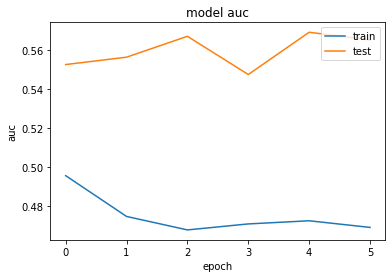

In [97]:
import matplotlib.pyplot as plt
plt.plot(hist.history['auc_3'])
plt.plot(hist.history['val_auc_3'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [53]:
hist.history

{'loss': [0.6007495522499084,
  0.8348697423934937,
  1.0443501472473145,
  1.2403841018676758],
 'auc_1': [0.5017126202583313,
  0.42931342124938965,
  0.40737301111221313,
  0.40652236342430115],
 'val_loss': [0.4380074441432953,
  0.43419769406318665,
  0.48174676299095154,
  0.5320612192153931],
 'val_auc_1': [0.558103084564209,
  0.5142197012901306,
  0.4799881875514984,
  0.4279025197029114]}

In [90]:
test_pred = model.predict(data_test, batch_size=BATCH_SIZE, verbose=0)

In [91]:
test_pred

array([[4.9185276e-01, 1.5550743e-02, 3.0214533e-01, 9.0294634e-05,
        1.7785312e-01, 1.2507689e-02],
       [1.7943120e-01, 6.0667485e-02, 4.7475800e-02, 5.3176790e-01,
        1.3138953e-01, 4.9268067e-02],
       [1.6667527e-01, 5.8722589e-02, 4.4937395e-02, 5.5733550e-01,
        1.2480349e-01, 4.7525760e-02],
       ...,
       [1.3593674e-01, 5.3910993e-02, 3.6559042e-02, 6.2456965e-01,
        1.0515201e-01, 4.3871563e-02],
       [1.3009614e-01, 5.3649206e-02, 3.6060888e-02, 6.3404852e-01,
        1.0352029e-01, 4.2624976e-02],
       [5.2821308e-01, 2.1439256e-02, 2.2723429e-01, 3.7442290e-04,
        2.0610943e-01, 1.6629500e-02]], dtype=float32)

In [93]:
test_pred[0:, 1]

array([0.01555074, 0.06066748, 0.05872259, ..., 0.05391099, 0.05364921,
       0.02143926], dtype=float32)

In [80]:
submission = pd.DataFrame()
submission['id'] = test.index
submission['toxic'] = test_pred[0:, 0]
submission['severe_toxic'] = test_pred[0:, 1]
submission['obscene'] = test_pred[0:, 2]
submission['threat'] = test_pred[0:, 3]
submission['insult'] = test_pred[0:, 4]
submission['identity_hate'] = test_pred[0:, 5]



In [81]:
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.695320,0.103010,0.089683,0.080381,0.010491,0.021115
1,0000247867823ef7,0.146437,0.173210,0.154187,0.201381,0.172166,0.152619
2,00013b17ad220c46,0.152223,0.166386,0.152349,0.196146,0.156782,0.176114
3,00017563c3f7919a,0.182831,0.199159,0.102165,0.136930,0.235032,0.143883
4,00017695ad8997eb,0.143533,0.153496,0.156877,0.197888,0.140230,0.207975
...,...,...,...,...,...,...,...
89181,fffcd0960ee309b5,0.157636,0.165630,0.140038,0.202403,0.139662,0.194631
89182,fffd7a9a6eb32c16,0.112765,0.103944,0.123674,0.252696,0.214323,0.192599
89183,fffda9e8d6fafa9e,0.143949,0.156045,0.166744,0.185235,0.188520,0.159507
89184,fffe8f1340a79fc2,0.173544,0.145454,0.147510,0.205386,0.152891,0.175215


In [83]:
submission.to_csv('submission.csv', sep = ',', index = False)

In [92]:
4.9185276e-01 + 1.5550743e-02 + 3.0214533e-01 + 9.0294634e-05 +       1.7785312e-01+ 1.2507689e-02

0.999999936634